In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/user_ratings.csv')
df = df[['Username','BGGId','Rating']]
df.head()

,Username,BGGId,Rating
0,Tonydorrf,213788,8.0
1,tachyon14k,213788,8.0
2,Ungotter,213788,8.0
3,brainlocki3,213788,8.0
4,PPMP,213788,8.0


In [3]:
game_df = pd.read_csv('/content/games.csv')

In [4]:
df['Username'] = df['Username'].astype(str)
df['BGGId'] = df['BGGId'].astype(int)
df['Rating'] = df['Rating'].astype('float32')

In [5]:
user_ids = df['Username'].unique().tolist()
game_ids = df['BGGId'].unique().tolist()

In [6]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
game2game_encoded = {x: i for i,x in enumerate(game_ids)}

In [7]:
num_users = len(user2user_encoded)
num_games = len(game2game_encoded)

In [8]:
df['user'] = df['Username'].map(user2user_encoded)
df['game'] = df['BGGId'].map(game2game_encoded)
df['Rating'] = df['Rating'].values.astype(np.float32)

In [9]:
min_rating = min(df['Rating'])
max_rating = max(df['Rating'])
X = df[['user','game']].values
y = df[['Rating']]

In [10]:
scaler = MinMaxScaler()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
y_train, y_test = scaler.fit_transform(y_train), scaler.transform(y_test)

In [11]:
embeddings_size = 50

user_input = Input(name='user_input', shape=(1,))
user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embeddings_size)(user_input)
user_vec = Flatten(name='flatten_user')(user_embedding)

game_input = Input(name='game_input', shape=(1))
game_embedding = Embedding(name='game_embedding', input_dim = num_games, output_dim = embeddings_size)(game_input)
game_vec = Flatten(name='reshaped_game')(game_embedding)

prod = Dot(name='dot_product',normalize=True, axes=1)([user_vec, game_vec])

y_out = Dense(name='y_out', units=1, activation='linear')(prod)


model = Model(inputs=[user_input, game_input], outputs=y_out)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 game_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        13181050    ['user_input[0][0]']             
                                                                                                  
 game_embedding (Embedding)     (None, 1, 50)        502900      ['game_input[0][0]']             
                                                                                              

In [12]:
history = model.fit(x=[x_train[:,0], x_train[:,1]], y=y_train, epochs=50, batch_size = 5000, verbose=True)

Epoch 1/50
322/322 [==============================] - 39s 106ms/step - loss: 0.2421 - mean_squared_error: 0.2421
Epoch 2/50
322/322 [==============================] - 11s 33ms/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 3/50
322/322 [==============================] - 4s 14ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 4/50
322/322 [==============================] - 4s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/50
322/322 [==============================] - 5s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 6/50
322/322 [==============================] - 4s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 7/50
322/322 [==============================] - 3s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 8/50
322/322 [==============================] - 4s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 9/50
322/322 [==============================] - 3s 11ms/step - loss: 0.0026 - mean_squared_error: 0.002

Text(0.5, 0, 'epoch')

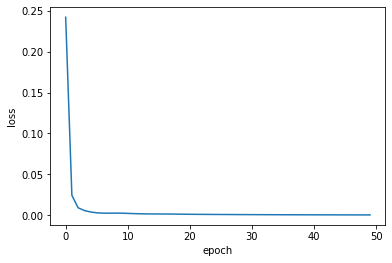

In [13]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

In [14]:
y_pred = model.predict(x=[x_test[:,0], x_test[:,1]])

12550/12550 [==============================] - 22s 2ms/step


In [15]:
mean_squared_error(y_test, y_pred, squared=False)

0.148115

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
model.save('/content/drive/MyDrive/Colab Notebooks/nn_model')

In [20]:
def user_recommendations(user, n_games,model):
    """
        Takes in a user, n_games and a model to returns their top n_games recommendations that they have not rated yet.

        Parameters:
            user(str): name of user
            n_games(int): number of games to show
            model: the model to use for predictions
            
        Returns:
            A list with each game as an index with a column for their estimated rating
    """
    # Remove the boardgames that the user have rated
    boardgame_id = df['BGGId'].unique()
    user_list = df.loc[df['Username']==user, 'BGGId']
    user_list = np.setdiff1d(boardgame_id, user_list)

    # Create sparse dataset with username and bggid
    testset = np.array([[user2user_encoded[user], game2game_encoded[bggid]] for bggid in user_list])
    # Test model on the testset and determine the boardgames with the highest rating
    predictions = model.predict(x=[testset[:,0],testset[:,1]])
    # Reshaped the predictions array by Transposing it. 
    top_ratings_idx = predictions.T[0].argsort()[::-1][:n_games]
    bgg_ids = user_list[top_ratings_idx]
    bgg_name = [game_df.loc[game_df['BGGId'] ==id]['Name'].values[0] for id in bgg_ids]
    print(f'Top boardgames for {user} in order are: \n {bgg_name}')
    

In [21]:
user_recommendations('bennygui',5, model)

314/314 [==============================] - 1s 2ms/step
Top boardgames for bennygui in order are: 
 ['General Quarters', 'Chachapoya', 'Processing: A Game of Serving Humanity', 'Magellan: Elcano', 'Timeline: Science Museum']
